Rainfall is often reported using daily totals, like 20 mm per day or 1 inch per day. For some applications like flash flooding prediction and the design of urban drainage systems, hourly or even 15-minute rainfall measurements are often more meaningful for accurate forecasting and process modeling. But what happens when we record rainfall at even higher temporal resolutions (e.g., 1-minute, 5-minute)? 

To investigate individual rainfall events, we will use a dataset recorded at 1-minute intervals at the Kansas State University Rocky Ford Experiment Station, near Manhattan, KS during July 2020. Rainfall observations were recorded using a tipping bucket rain gauge with an 9.6-inch funnel opening and a precision of 0.1 mm per tipping (model TE525MM, Texas Electronics, Inc.). This dataset has 44,638 values (60 minutes per hour x 24 hours per day x 31 days). It would take slightly over 122 years of daily rainfall data to reach the same number of records presented here for just one month.

To identify individual rainfall events from 1-minute interval observations, we will use a for loop to iterate over each record. During this process, a state variable will track whether we are inside or outside of a rainfall event as follows: if the recorded rainfall for the current minute is greater than 0 mm, this indicates the occurrence of a rainfall event. Conversely, a reading of zero rainfall does not immediately signal the end of an event. This is because of the possibility of light rain that may not activate the gauge's tipping mechanism in that specific minute. To address this intra-event intermitency, we wil use an "inter-event time" criterion that defines a specific duration of continuous zero rainfall measurements, which, when met, confirms the conclusion of the ongoing rainfall event. I added a few articles in the References section in case you want to dive deeper into this topic.


In [13]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pprint import pprint


In [14]:
# Load rainfall data
df = pd.read_csv('../datasets/rocky_ford_july_2020_1min.csv',
                 skiprows=[1,2], na_values='NAN',
                 parse_dates=['TIMESTAMP'], date_format='%Y-%m-%d %H:%M:%S')

# Show length of dataframe
print(df.shape)

# Display a few rows to inspect the nature of the dataset
df.head(3)


(44638, 2)


,TIMESTAMP,Rain_mm
0,2020-07-01 00:01:00,0.0
1,2020-07-01 00:02:00,0.0
2,2020-07-01 00:03:00,0.0


In [4]:
# Identify individual rainfall events

# Create empty list to append summary metrics for each rainfall event
D = []

# Settings
within_event = False # Boolean to denote whether iteration is within a rainfall event or not
interval = 1 # Measurement interval of the raw data (1-minute in our study)
inter_event_time = 60 # Minimum inter-event time (MIT) in interval units (minutes in our study)

# Initialize variables
counter_no_rainfall = 0 # Track time without rainfall events
event_rain_time = 0 # Time during the event with measurable rainfall
event_rain_amount = 0 # Total rainfall amount per event in millimeters
event_max_intensity = 0 # Maximum rainfall intensity (converted to mm/hr)

# Iterate over each meausrements
for k,row in df.iterrows():
    
    # Get current rainfall amount
    rain = row['Rain_mm']
    
    # If rainfall is greater than zero that means we are within a rainfall event...
    if rain > 0:
        
        # ...so we proceed to reset the counter
        counter_no_rainfall = 0

        # Set parameters if this the first value greater than zero rainfall
        if not within_event:
            
            # Convert to True because now we are inside a new event
            within_event = True
            
            # Rainfall is totaled at the end of the minute, so we grab the previous minute
            idx_start = k - 1

        # Track duration, amount, and intensity of the precipitation event
        event_rain_time += interval
        event_rain_amount += rain
        
        # Update maximum interval rainfall rate
        event_max_intensity = max(event_max_intensity, rain) 

    else:
        # Track number of intervals without rainfall
        counter_no_rainfall += interval 

    # End of the rainfall event if there is a certain user-specified cumulative period without rainfall
    if within_event and (counter_no_rainfall == inter_event_time):

        # Get timestamp right before first rainfall for this event
        event_start_time = df["TIMESTAMP"].iloc[idx_start]
        
        # Get timestamp of last recorded rainfall for this event
        idx_end = k - inter_event_time
        event_end_time = df['TIMESTAMP'].iloc[idx_end]
        
        # Compute total duration of the event (including short periods without rain)
        event_duration = (event_end_time - event_start_time).total_seconds()/60 + 1

        # Append dictionary to list of events
        D.append({'event_start_time':event_start_time,
                  'event_end_time':event_end_time,
                  'event_rain_time':event_rain_time,
                  'event_duration':event_duration,
                  'event_amount':round(event_rain_amount,1),
                  'event_max_intensity':event_max_intensity*60/interval, # converted to mm/hr
                  'event_timestamps': df.loc[idx_start:idx_end, 'TIMESTAMP'].values,
                  'event_rain': df.loc[idx_start:idx_end, 'Rain_mm'].values}
                )
        
        # Reset variables before starting new iteration
        within_event = False
        event_rain_time = 0
        event_rain_amount = 0
        event_max_intensity = 0
        
        # Print to let us know the code is working
        print(f'Saved event {event_start_time} - {event_end_time}')
        
        

Saved event 2020-07-03 01:24:00 - 2020-07-03 01:57:00
Saved event 2020-07-03 03:26:00 - 2020-07-03 03:27:00
Saved event 2020-07-03 05:04:00 - 2020-07-03 05:47:00
Saved event 2020-07-05 16:21:00 - 2020-07-05 16:26:00
Saved event 2020-07-07 05:45:00 - 2020-07-07 05:46:00
Saved event 2020-07-09 01:55:00 - 2020-07-09 05:30:00
Saved event 2020-07-09 06:49:00 - 2020-07-09 06:50:00
Saved event 2020-07-14 06:48:00 - 2020-07-14 07:24:00
Saved event 2020-07-15 03:47:00 - 2020-07-15 10:09:00
Saved event 2020-07-18 04:15:00 - 2020-07-18 04:22:00
Saved event 2020-07-18 07:40:00 - 2020-07-18 07:41:00
Saved event 2020-07-19 05:54:00 - 2020-07-19 05:55:00
Saved event 2020-07-20 06:03:00 - 2020-07-20 07:34:00
Saved event 2020-07-20 11:09:00 - 2020-07-20 11:10:00
Saved event 2020-07-20 23:01:00 - 2020-07-21 01:12:00
Saved event 2020-07-21 05:03:00 - 2020-07-21 08:32:00
Saved event 2020-07-21 11:02:00 - 2020-07-21 11:33:00
Saved event 2020-07-24 10:50:00 - 2020-07-24 10:51:00
Saved event 2020-07-26 21:52

In [5]:
# Explore one of the events
pprint(D[3])

{'event_amount': 0.2,
 'event_duration': 6.0,
 'event_end_time': Timestamp('2020-07-05 16:26:00'),
 'event_max_intensity': 6.0,
 'event_rain': array([0. , 0.1, 0. , 0. , 0. , 0.1]),
 'event_rain_time': 2,
 'event_start_time': Timestamp('2020-07-05 16:21:00'),
 'event_timestamps': array(['2020-07-05T16:21:00.000000000', '2020-07-05T16:22:00.000000000',
       '2020-07-05T16:23:00.000000000', '2020-07-05T16:24:00.000000000',
       '2020-07-05T16:25:00.000000000', '2020-07-05T16:26:00.000000000'],
      dtype='datetime64[ns]')}


In [6]:
# Conver resulting dictionary into a new Dataframe for easier data exploration
df_events = pd.DataFrame(D)
df_events.head(3)


,event_start_time,event_end_time,event_rain_time,event_duration,event_amount,event_max_intensity,event_timestamps,event_rain
0,2020-07-03 01:24:00,2020-07-03 01:57:00,29,34.0,5.9,30.0,"[2020-07-03T01:24:00.000000000, 2020-07-03T01:...","[0.0, 0.1, 0.1, 0.5, 0.4, 0.5, 0.4, 0.3, 0.3, ..."
1,2020-07-03 03:26:00,2020-07-03 03:27:00,1,2.0,0.1,6.0,"[2020-07-03T03:26:00.000000000, 2020-07-03T03:...","[0.0, 0.1]"
2,2020-07-03 05:04:00,2020-07-03 05:47:00,11,44.0,2.7,42.0,"[2020-07-03T05:04:00.000000000, 2020-07-03T05:...","[0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [7]:
# Find event with largest duration
idx_max_duration = df_events['event_duration'].argmax()
event_max_duration = df_events.loc[idx_max_duration, 'event_duration']

print(f'Maximum duration: {event_max_duration} minutes. Event #{idx_max_duration}')


Maximum duration: 383.0 minutes. Event #8


In [8]:
# Find event with largest duration
idx_max_amount = df_events['event_amount'].argmax()
event_max_amount = df_events.loc[idx_max_amount, 'event_amount']

print(f'Maximum amount: {event_max_amount} mm. Event #{idx_max_amount}')


Maximum amount: 41.3 mm. Event #12


In [9]:
# Find event with maximum rainfall intensity
# Find event with largest duration
idx_max_intensity = df_events['event_max_intensity'].argmax()
event_max_intensity = df_events.loc[idx_max_intensity, 'event_max_intensity']

print(f'Maximum intensity: {event_max_intensity} mm/hr. Event #{idx_max_intensity}')


Maximum intensity: 198.0 mm/hr. Event #12


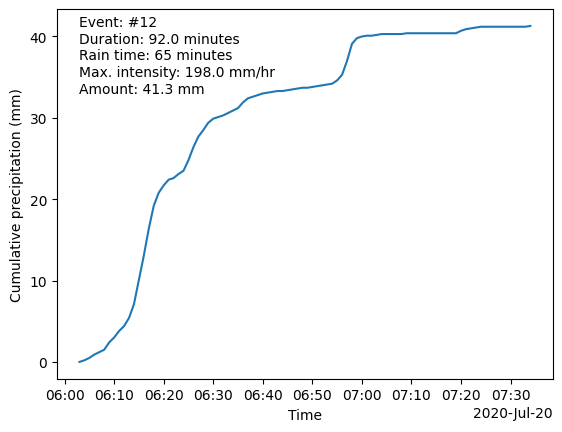

In [11]:
# Select event
event = 12

# Generate quick plot
locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
fmt = mdates.ConciseDateFormatter(locator)

# Re-define for more compact code and easy figure text insertion
x = df_events.loc[event, 'event_timestamps']
y = df_events.loc[event, 'event_rain'].cumsum()

plt.figure()
plt.plot(x, y)
plt.xlabel('Time')
plt.ylabel('Cumulative precipitation (mm)')
plt.gca().xaxis.set_major_formatter(fmt)
plt.text(x[0], y[-1], f"Event: #{event}")
plt.text(x[0], y[-1]*0.95, f"Duration: {df_events.loc[event, 'event_duration']} minutes")
plt.text(x[0], y[-1]*0.9, f"Rain time: {df_events.loc[event, 'event_rain_time']} minutes")
plt.text(x[0], y[-1]*0.85, f"Max. intensity: {df_events.loc[event, 'event_max_intensity']} mm/hr")
plt.text(x[0], y[-1]*0.8, f"Amount: {df_events.loc[event, 'event_amount']} mm")

plt.show()


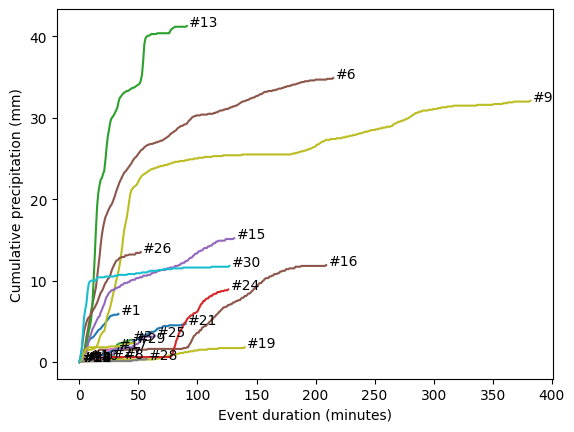

In [12]:
# Plot all the events together
plt.figure()
for k,row in df_events.iterrows():
    x = np.arange(row['event_duration'])
    y = row['event_rain'].cumsum()
    
    # Generate plot
    plt.plot(x, y)
    plt.text(x[-1]+2, y[-1], f'#{k+1}') # Added 1 to match a possible publsihed table
    
plt.xlabel('Event duration (minutes)')
plt.ylabel('Cumulative precipitation (mm)')
plt.show()


## References

Dunkerley, D. (2015). Intra‐event intermittency of rainfall: An analysis of the metrics of rain and no‐rain periods. Hydrological Processes, 29(15), 3294-3305.

Dyer, D. W., Patrignani, A., & Bremer, D. (2022). Measuring turfgrass canopy interception and 
throughfall using co-located pluviometers. Plos one, 17(9), e0271236. https://doi.org/10.1371/journal.pone.0271236